In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import descartes as ds
import geopandas
%matplotlib inline

In [2]:
DBNAME = "opportunity_youth"
conn = psycopg2.connect(dbname=DBNAME)

In [3]:
map = geopandas.read_file('reg10puma.shp')


Area, not south - 0 (03), 1 (04), 2 (05), 8 (09), 9 (08), 10 (07), 11 (02), 12 (01), 13 (06),  14 (16),  
Area, south     - 3 (11), 4 (10), 5 (13), 6 (14), 7 (12), 15 (15)

### Here we isolate from the shapefile the PUMAs in King County

In [4]:
map.loc[0:15, 'geometry']
king = map[0:16]


In [5]:
oy_count = pd.read_sql("""SELECT SUM(pwgtp) AS oy_count, n.puma_name, p.puma
                                           FROM pums_2017 p
                                           JOIN puma_names_2010 n
                                           ON p.puma = n.puma
                                           WHERE p.puma BETWEEN '11601' AND '11616'
                                           AND (p.esr = '3' OR p.esr = '6'
                                                OR p.wkl = '2' OR p.wkl = '3')
                                           AND p.sch = '1'
                                           AND p.agep BETWEEN '16' AND '24'
                                           GROUP BY n.puma_name, p.puma
                                           ORDER BY oy_count DESC
                                           ;""", conn)
oy_count = oy_count.set_index('puma')
oy_count


,oy_count,puma_name
puma,,
11611,2038.0,"King County (West Central)--Burien, SeaTac, Tu..."
11613,2006.0,King County (Southwest Central)--Kent City ...
11612,1977.0,"King County (Far Southwest)--Federal Way, Des ..."
11610,1853.0,"King County (Central)--Renton City, Fairwood, ..."
11614,1530.0,King County (Southwest)--Auburn City & Lakelan...
11602,1325.0,Seattle City (Northeast) ...
11615,1210.0,"King County (Southeast)--Maple Valley, Covingt..."
11608,1086.0,King County (Northwest Central)--Greater Belle...
11603,1032.0,Seattle City (Downtown)--Queen Anne & Magnolia...


### Attach PUMA codes to each region and locate the southern area

In [6]:
king['puma'] = ['11603', '11604', '11605', '11611', '11610', '11613', '11614', '11612', '11609', '11608', '11607', '11602', '11601', '11606', '11616', '11615']
king['is_south'] = [False, False, False, True, True, True, True, True, False, False, False, False, False, False, False, True]
#king = king.join(oy_count, on='puma')
king = king.set_index('puma')
king['oy'] = oy_count['oy_count']
southking = king.sort_values('puma')[-7:-1]
southking

<ipython-input-6-acc627ba2579>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king['puma'] = ['11603', '11604', '11605', '11611', '11610', '11613', '11614', '11612', '11609', '11608', '11607', '11602', '11601', '11606', '11616', '11615']
<ipython-input-6-acc627ba2579>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king['is_south'] = [False, False, False, True, True, True, True, True, False, False, False, False, False, False, False, True]


,geometry,is_south,oy
puma,,,
11610,"POLYGON ((-122.12208 47.50248, -122.12208 47.5...",True,1853.0
11611,"POLYGON ((-122.21746 47.44117, -122.21759 47.4...",True,2038.0
11612,"POLYGON ((-122.43804 47.77812, -122.40086 47.7...",True,1977.0
11613,"POLYGON ((-122.14580 47.34353, -122.14627 47.3...",True,2006.0
11614,"POLYGON ((-122.11388 47.21865, -122.11418 47.2...",True,1530.0
11615,"POLYGON ((-121.37967 47.08676, -121.37977 47.0...",True,1210.0


### Plot the PUMAS in the south

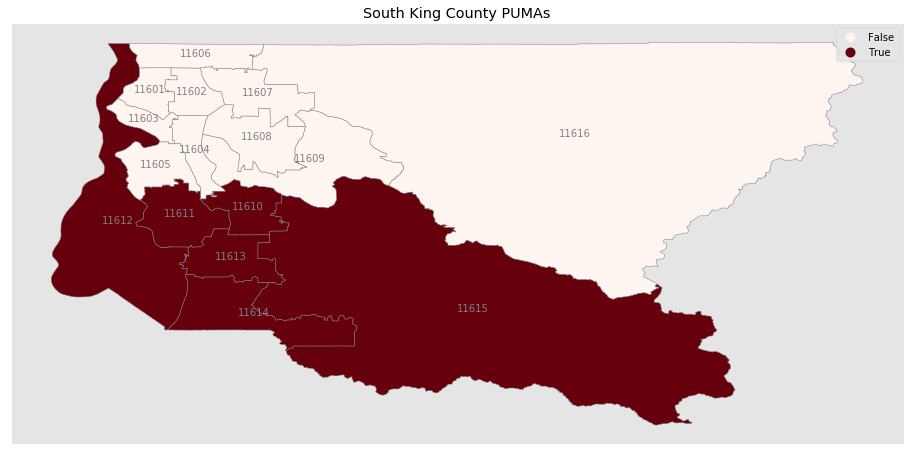

In [9]:
fig, ax = plt.subplots(figsize=(16,8))

king.plot( ax=ax, cmap='Reds',
          edgecolor='grey', column='is_south',
          categorical=True, legend=True)
# king.plot(ax=ax[1], cmap='Reds',
#           edgecolor='grey', column='oy',
#           legend=True)

plt.style.use('ggplot')

for i, geo in king.centroid.iteritems():
    ax.annotate(s=i, xy=[geo.x, geo.y], xytext=(geo.x-.03,geo.y), color="grey")

    # show the subplot
    ax.figure


ax.set_title('South King County PUMAs')

ax.set_xticks([])

ax.set_yticks([])


plt.savefig('../../visualizations/pumas-map.png', format='png')

### Plot the OYs in South King County

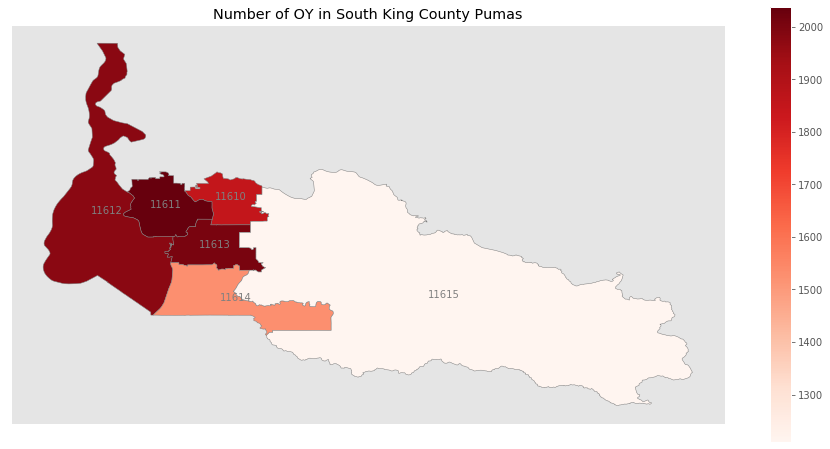

In [10]:
fig, ax = plt.subplots(figsize=(16,8))

southking.plot(ax=ax, cmap='Reds',
          edgecolor='grey', column='oy',
          legend=True)

for i, geo in southking.centroid.iteritems():
    ax.annotate(s=i, xy=[geo.x, geo.y], xytext=(geo.x-.03,geo.y), color="grey")
ax.set_title('Number of OY in South King County Pumas')

ax.set_xticks([])

ax.set_yticks([])
plt.savefig('../../visualizations/oy-map.png', format='png')